In [22]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [23]:

# Import necessary libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum, col, hour, concat_ws, to_date, date_format

# Step 1: Initialize a Spark session
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
# Step 2: Load your CSV file into a Spark DataFrame
data = spark.read.csv("June2024.csv", header=True, inferSchema=True)


In [24]:

# Step 3: Convert 'TICKET_ISSUE_DATE' to the correct format (DD/MM/YYYY to YYYY-MM-DD)
data = data.withColumn("TICKET_ISSUE_DATE", to_date(col("TICKET_ISSUE_DATE"), "dd/MM/yyyy"))

# Step 4: Extract hour from 'TICKET_ISSUE_TIME' and combine with 'TICKET_ISSUE_DATE'
# Extract hour as a two-digit string and concatenate with the formatted date
data = data.withColumn("TICKET_ISSUE_HOUR", date_format(col("TICKET_ISSUE_TIME"), "HH"))
data = data.withColumn("DATE_HOUR", concat_ws(" ", date_format(col("TICKET_ISSUE_DATE"), "yyyy-MM-dd"), col("TICKET_ISSUE_HOUR")))

# Step 5: Group by 'DATE_HOUR' and calculate the sum for 'NO_OF_ADULT' and 'NO_OF_CHILD'
summary_data = data.groupBy("DATE_HOUR") \
    .agg(
        spark_sum("NO_OF_ADULT").alias("NO_OF_ADULT"),
        spark_sum("NO_OF_CHILD").alias("NO_OF_CHILD")
    )
# Step 5: Convert Spark DataFrame to pandas DataFrame for further processing
df = summary_data.toPandas()
df

,DATE_HOUR,NO_OF_ADULT,NO_OF_CHILD
0,2024-06-15 08,10777,162
1,2024-06-18 06,10133,55
2,2024-06-01 00,1051,2
3,2024-06-18 11,18539,88
4,2024-06-18 09,10996,87
...,...,...,...
616,2024-06-02 22,133,1
617,2024-06-12 22,118,0
618,2024-06-05 23,403,2
619,2024-06-12 23,474,2


In [25]:
import pandas as pd
# Step 7: Convert 'DATE_HOUR' to datetime format, then set as the index
df['DATE_HOUR'] = pd.to_datetime(df['DATE_HOUR'], format='%Y-%m-%d %H')
df.set_index('DATE_HOUR', inplace=True)
df.sort_index(inplace=True)
print(df)

                     NO_OF_ADULT  NO_OF_CHILD
DATE_HOUR                                    
2024-05-31 01:00:00          242            0
2024-05-31 02:00:00          531            0
2024-05-31 03:00:00          827            0
2024-05-31 04:00:00          671            0
2024-05-31 05:00:00          488            1
...                          ...          ...
2024-06-30 13:00:00         9202          191
2024-06-30 14:00:00         4841           75
2024-06-30 15:00:00         1387           10
2024-06-30 16:00:00          232            6
2024-06-30 17:00:00            5            0

[621 rows x 2 columns]


In [26]:
# Step 7: Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(df)
print(scaled_data)


[[0.00810493 0.        ]
 [0.01782411 0.        ]
 [0.02777871 0.        ]
 ...
 [0.04661174 0.02941176]
 [0.00776862 0.01764706]
 [0.00013452 0.        ]]


In [27]:
# Step 8: Stop the Spark session
spark.stop()

In [28]:

split_ratio = 0.7
split_index = int(len(scaled_data) * split_ratio)

# Create Train and Test datasets
Train = scaled_data[:split_index]
Test = scaled_data[split_index:]

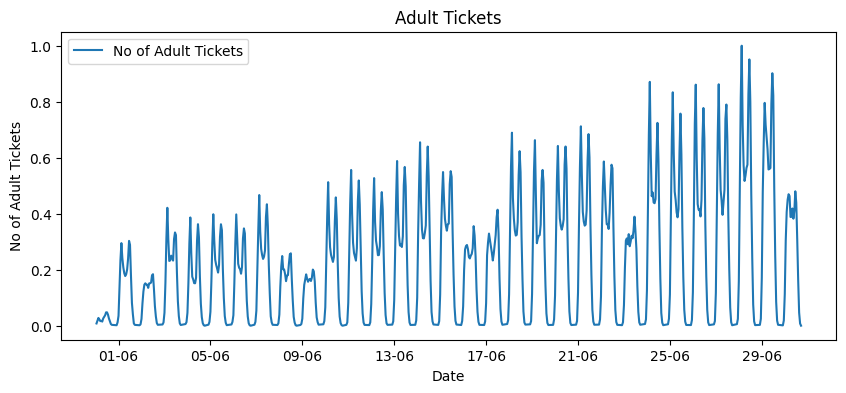

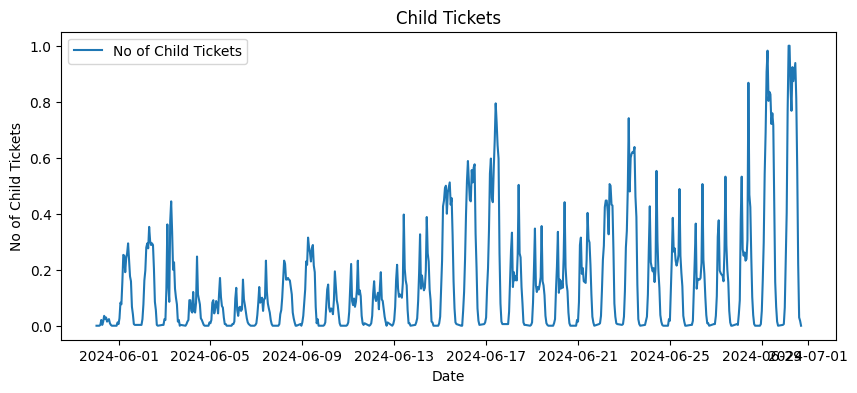

In [29]:
import matplotlib.dates as mdates

# Adult Tickets
plt.figure(figsize=(10, 4))
adult_scaled = [x for x, y in scaled_data]
plt.plot(df.index, adult_scaled, label='No of Adult Tickets')
plt.title('Adult Tickets')
plt.xlabel('Date')
plt.ylabel('No of Adult Tickets')
plt.legend()

# Set date format to only day and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
# Set major ticks to appear every 4 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

plt.show()

# Child Tickets
plt.figure(figsize=(10, 4))
child_scaled = [y for x, y in scaled_data]
plt.plot(df.index, child_scaled, label='No of Child Tickets')
plt.title('Child Tickets')
plt.xlabel('Date')
plt.ylabel('No of Child Tickets')
plt.legend()


plt.show()


In [ ]:
n_input = 24
n_features = 2
# time series generation on test data
#This tool automatically creates sequences of data for training a time series model. 
# It generates small batches of data in the format needed for time series models.
generator = TimeseriesGenerator(Train, Train, length = n_input, batch_size = 1)   

In [31]:
print(Train)
generator[0]#first batch of data
      

[[8.10492685e-03 0.00000000e+00]
 [1.78241130e-02 0.00000000e+00]
 [2.77787120e-02 0.00000000e+00]
 [2.25323693e-02 0.00000000e+00]
 [1.63780057e-02 2.94117647e-03]
 [1.74205482e-02 2.05882353e-02]
 [1.47973768e-02 2.94117647e-03]
 [2.59963007e-02 1.47058824e-02]
 [3.16462082e-02 3.52941176e-02]
 [3.72961157e-02 2.35294118e-02]
 [4.77888011e-02 2.94117647e-02]
 [4.77215403e-02 1.47058824e-02]
 [3.93139398e-02 2.05882353e-02]
 [2.57272574e-02 2.35294118e-02]
 [1.55708761e-02 8.82352941e-03]
 [6.15436354e-03 2.94117647e-03]
 [3.12762738e-03 0.00000000e+00]
 [1.74878090e-03 0.00000000e+00]
 [1.17706407e-02 1.17647059e-02]
 [3.53119220e-02 5.88235294e-03]
 [1.39263494e-01 2.64705882e-02]
 [2.33865815e-01 8.23529412e-02]
 [2.95039516e-01 7.64705882e-02]
 [2.41432655e-01 1.55882353e-01]
 [2.08777535e-01 2.52941176e-01]
 [1.87455860e-01 2.50000000e-01]
 [1.77434000e-01 1.91176471e-01]
 [1.83790146e-01 2.41176471e-01]
 [2.00908021e-01 2.58823529e-01]
 [2.39784765e-01 2.94117647e-01]
 [3.029762

(array([[[0.00810493, 0.        ],
         [0.01782411, 0.        ],
         [0.02777871, 0.        ],
         [0.02253237, 0.        ],
         [0.01637801, 0.00294118],
         [0.01742055, 0.02058824],
         [0.01479738, 0.00294118],
         [0.0259963 , 0.01470588],
         [0.03164621, 0.03529412],
         [0.03729612, 0.02352941],
         [0.0477888 , 0.02941176],
         [0.04772154, 0.01470588],
         [0.03931394, 0.02058824],
         [0.02572726, 0.02352941],
         [0.01557088, 0.00882353],
         [0.00615436, 0.00294118],
         [0.00312763, 0.        ],
         [0.00174878, 0.        ],
         [0.01177064, 0.01176471],
         [0.03531192, 0.00588235],
         [0.13926349, 0.02647059],
         [0.23386581, 0.08235294],
         [0.29503952, 0.07647059],
         [0.24143266, 0.15588235],
         [0.20877753, 0.25294118]]]),
 array([[0.18745586, 0.25      ]]))

In [32]:
model = Sequential([
    Bidirectional(LSTM(units=100, activation='tanh'), input_shape=(n_input, n_features)),
    Dense(units=2, activation='tanh')
])

/home/jeev/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# compile the model

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [34]:
# model training

history = model.fit(generator, epochs = 10)


/home/jeev/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7916 - loss: 0.0155
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8564 - loss: 0.0065
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8377 - loss: 0.0056
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8107 - loss: 0.0046
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8398 - loss: 0.0042
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8733 - loss: 0.0034
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8540 - loss: 0.0044
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8652 - loss: 0.0040
Epoch 9/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8436 - loss: 0.0027
Epoch 10/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8912 - loss: 0.0033


In [35]:
Test

array([[6.84311418e-01, 3.08823529e-01],
       [6.00773499e-01, 2.97058824e-01],
       [3.61459559e-01, 2.17647059e-01],
       [1.81772322e-01, 1.11764706e-01],
       [5.67681184e-02, 3.23529412e-02],
       [1.45619640e-02, 1.17647059e-02],
       [3.53119220e-03, 0.00000000e+00],
       [3.96838742e-03, 5.88235294e-03],
       [2.25323693e-02, 8.82352941e-03],
       [1.04624180e-01, 3.52941176e-02],
       [3.47502943e-01, 1.26470588e-01],
       [4.97057340e-01, 2.35294118e-01],
       [5.86514209e-01, 2.85294118e-01],
       [4.98234404e-01, 4.23529412e-01],
       [4.12981335e-01, 4.47058824e-01],
       [3.62838406e-01, 4.47058824e-01],
       [3.61425929e-01, 4.08823529e-01],
       [3.45619640e-01, 3.26470588e-01],
       [4.03901127e-01, 5.05882353e-01],
       [5.03749790e-01, 5.00000000e-01],
       [5.74978981e-01, 4.32352941e-01],
       [5.62401211e-01, 4.29411765e-01],
       [3.52110308e-01, 2.73529412e-01],
       [1.76458719e-01, 7.94117647e-02],
       [5.626366

In [36]:
# time series generation on test data

test_generator = TimeseriesGenerator(Test, Test, length = n_input, batch_size = 1)


In [37]:
# model evaluation on test data
test_loss = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8443 - loss: 0.0059
Test Loss: [0.007875722832977772, 0.8518518805503845]


In [38]:
num_sequences = len(test_generator)
print("Total number of sequences:", num_sequences)

Total number of sequences: 162


In [39]:
# prediction and output

x_test, y_test = test_generator[85]
prediction = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [40]:
x_test

array([[[0.0144947 , 0.        ],
        [0.00275769, 0.        ],
        [0.00238776, 0.00294118],
        [0.02034639, 0.00294118],
        [0.11918614, 0.01764706],
        [0.3904826 , 0.12647059],
        [0.72059862, 0.24117647],
        [0.86090466, 0.36470588],
        [0.59801581, 0.13235294],
        [0.43443753, 0.16764706],
        [0.41409114, 0.16470588],
        [0.41506642, 0.16470588],
        [0.39028081, 0.17058824],
        [0.44960484, 0.22352941],
        [0.66177905, 0.50588235],
        [0.77753489, 0.23529412],
        [0.66890869, 0.18529412],
        [0.36209854, 0.10294118],
        [0.17733311, 0.03823529],
        [0.05643181, 0.00882353],
        [0.01197242, 0.00882353],
        [0.0023205 , 0.        ],
        [0.00491004, 0.00588235],
        [0.01678157, 0.00588235],
        [0.1170338 , 0.03529412]]])

In [41]:
y_test

array([[0.40665882, 0.10588235]])

In [43]:
# Calculate the error percentage
import numpy as np
error_percentage = np.abs((y_test[0] - prediction[0]) / y_test[0]) * 100
print(f"Actual: {y_test[0]}, Predicted: {prediction}")
print(f"Error Percentage: {error_percentage}")
accuracy = 100 - np.mean(error_percentage)
print(f"Accuracy: {accuracy}%")

Actual: [0.40665882 0.10588235], Predicted: [[0.34017065 0.13509585]]
Error Percentage: [16.34986497 27.59052465]
Accuracy: 78.02980518699093%
